# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 6.19 s


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [4]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [5]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [4]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 487 ms


In [5]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


In [8]:
instant_video.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,2014-05-03
1,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,2012-09-03
2,"[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,2013-10-16
3,"[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,2013-10-30
4,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,2009-02-11


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

In [9]:
movies_tv["overall"].value_counts()

5    60511
4    21022
3     9166
1     4726
2     4575
Name: overall, dtype: int64

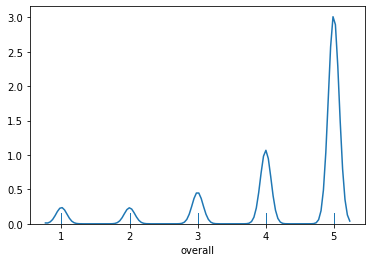

In [10]:
movies1= sns.distplot(movies_tv["overall"], rug=True, hist=False)

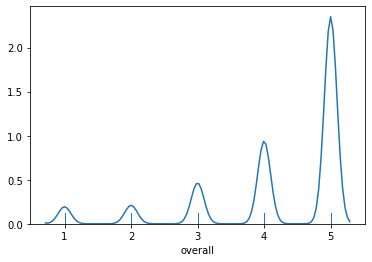

In [11]:
movies1= sns.distplot(instant_video["overall"], rug=True, hist=False)

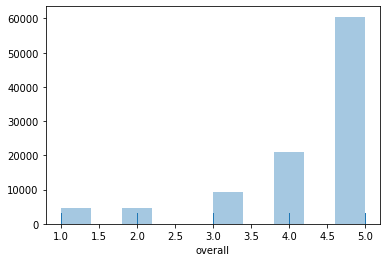

In [12]:
sns.distplot(movies_tv["overall"], bins=10, kde=False, rug=True)

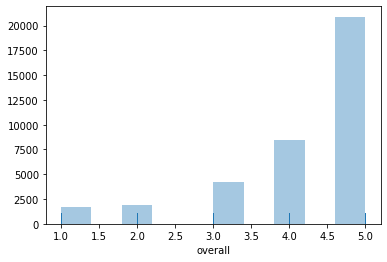

In [13]:
sns.distplot(instant_video["overall"], bins=10, kde=False, rug=True)

We can see a good results for reviews in terms of scoring because approximately 60% of reviews have the best scoring (5)

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

In [6]:
#Creamos la columna año y mes para analizar comportamiento
movies_tv["Year"]=movies_tv["datetime"].dt.year
instant_video["Year"]=instant_video["datetime"].dt.year
movies_tv["Month"]=movies_tv["datetime"].dt.month
instant_video["Month"]=instant_video["datetime"].dt.month

In [15]:
movies_tv.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime,Year,Month
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26,2008,2
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30,2013,12
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30,2013,12
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13,2008,2
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22,2013,12


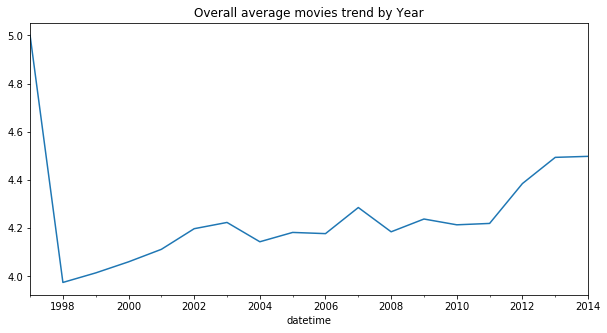

In [21]:
movies_trend = movies_tv.groupby(movies_tv['datetime'].dt.to_period('y')).mean()
plt.figure(figsize=(10,5))
plt.title("Overall average movies trend by Year")
movies_trend["overall"].plot.line()

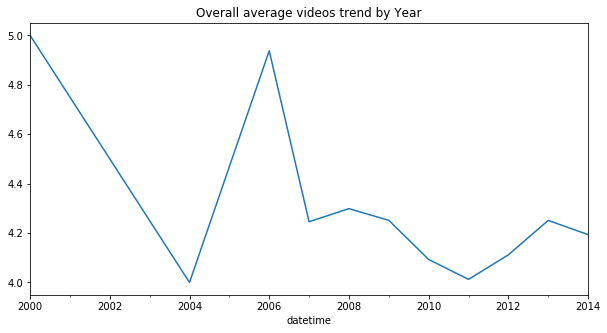

In [20]:
videos_trend = instant_video.groupby(instant_video['datetime'].dt.to_period('y')).mean()
plt.figure(figsize=(10,5))
plt.title("Overall average videos trend by Year")
videos_trend["overall"].plot.line()

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

In [7]:
movies_tv["length"]= movies_tv["reviewText"].apply(lambda x: len(nltk.word_tokenize(x)))

In [32]:
movies_tv.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime,Year,Month,length
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26,2008,2,62
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30,2013,12,23
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30,2013,12,63
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13,2008,2,34
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22,2013,12,29


In [8]:
instant_video["length"]= instant_video["reviewText"].apply(lambda x: len(nltk.word_tokenize(x)))

In [34]:
instant_video.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime,Year,Month,length
0,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,2014-05-03,2014,5,32
1,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,2012-09-03,2012,9,38
2,"[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,2013-10-16,2013,10,33
3,"[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,2013-10-30,2013,10,24
4,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,2009-02-11,2009,2,262


In [44]:
plot_movies = movies_tv.groupby(["Year"]).mean().reset_index()
plot_movies.head()

,Year,overall,unixReviewTime,Month,length
0,1997,5.000000,8.796096e+08,11.000000,69.333333
1,1998,3.975207,9.105439e+08,10.785124,150.834711
2,1999,4.014799,9.359003e+08,8.417900,158.874560
3,2000,4.060704,9.617792e+08,6.266632,203.674605
4,2001,4.112570,9.939775e+08,6.499650,237.018382


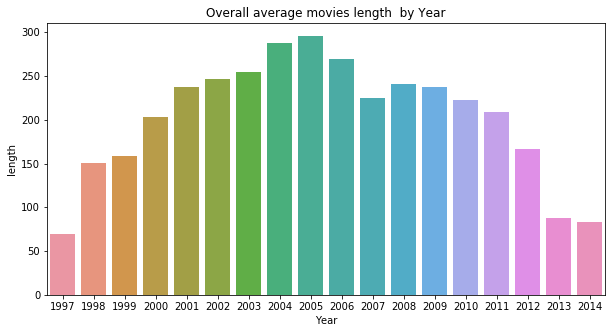

In [47]:
plt.figure(figsize=(10,5))
plt.title("Overall average movies length  by Year")
Movies_1_3= sns.barplot(x="Year", y="length", data=plot_movies)

In [46]:
plot_instant_video= instant_video.groupby(["Year"]).mean().reset_index()
plot_instant_video.head()

,Year,overall,unixReviewTime,Month,length
0,2000,5.000000,9.754560e+08,11.000000,79.000000
1,2004,4.000000,1.098403e+09,10.000000,245.000000
2,2006,4.937500,1.158732e+09,9.187500,409.687500
3,2007,4.245763,1.189331e+09,8.779661,335.567797
4,2008,4.298701,1.215109e+09,6.562771,318.099567


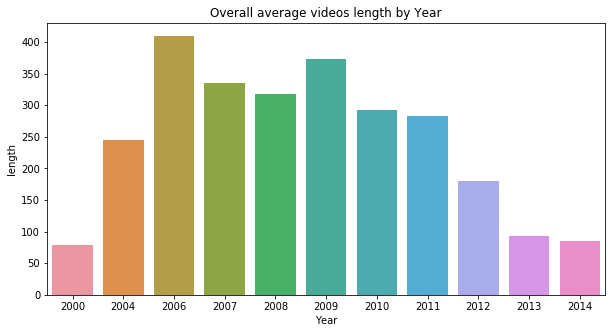

In [49]:
plt.figure(figsize=(10,5))
plt.title("Overall average videos length by Year")
Videos_1_3= sns.barplot(x="Year", y="length", data=plot_instant_video)

We can see how overall average rate of reviews range from 4 to 5 , where in the first decade of the 2000s it was lower and has been growing after 2011

--------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


In [10]:
#Definimos funcion
def get_top_n_words(corpus,n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [11]:
# List of words for all instant videos reviews 
freq_instant=get_top_n_words(instant_video["reviewText"])

In [12]:
# List of words for all movies reviews
freq_movies=get_top_n_words(movies_tv["reviewText"])

In [13]:
# List of words for good instant videos reviews where overall >3
good_instant_reviews=instant_video[instant_video["overall"]>3]
freq_instant_good_reviews=get_top_n_words(good_instant_reviews["reviewText"])

In [14]:
# List of words for good movies reviews where overall >3
good_movies_reviews=movies_tv[movies_tv["overall"]>3]
freq_movies_good_reviews=get_top_n_words(good_movies_reviews["reviewText"])

In [24]:
# List of words for bad instant videos reviews where overall <3
bad_instant_reviews=instant_video[instant_video["overall"]<3]
freq_instant_bad_reviews=get_top_n_words(bad_instant_reviews["reviewText"])

In [25]:
# List of words for bad movies reviews where overall <3
bad_movies_reviews=movies_tv[movies_tv["overall"]<3]
freq_movies_bad_reviews=get_top_n_words(bad_movies_reviews["reviewText"])

In [32]:
freq_movies_top=freq_movies[0:10]
freq_movies_top

[('movie', 146139),
 ('film', 117896),
 ('like', 49747),
 ('great', 46391),
 ('good', 44771),
 ('quot', 44715),
 ('just', 43336),
 ('time', 39939),
 ('story', 35359),
 ('really', 29202)]

In [33]:
freq_instant_top=freq_instant[0:10]
freq_instant_top

[('season', 16885),
 ('like', 14748),
 ('series', 12901),
 ('good', 12663),
 ('just', 11465),
 ('great', 10594),
 ('34', 10184),
 ('really', 9097),
 ('love', 8989),
 ('watch', 8989)]

In [34]:
freq_instant_good_reviews=freq_instant_good_reviews[0:10]
freq_instant_good_reviews

[('season', 14255),
 ('series', 10914),
 ('like', 10206),
 ('good', 9692),
 ('great', 9375),
 ('love', 8003),
 ('just', 7342),
 ('34', 7138),
 ('watch', 6912),
 ('characters', 6685)]

In [35]:
freq_movies_good_reviews=freq_movies_good_reviews[0:10]
freq_movies_good_reviews

[('movie', 115580),
 ('film', 93835),
 ('great', 41013),
 ('like', 37190),
 ('quot', 34366),
 ('good', 34320),
 ('time', 32859),
 ('just', 31716),
 ('story', 28559),
 ('best', 24257)]

In [36]:
freq_instant_bad_reviews=freq_instant_bad_reviews[0:10]
freq_instant_bad_reviews

[('just', 2198),
 ('like', 2123),
 ('movie', 1784),
 ('34', 1412),
 ('film', 1206),
 ('really', 1176),
 ('good', 1148),
 ('don', 1021),
 ('time', 1002),
 ('people', 958)]

In [41]:
freq_movies_bad_reviews=freq_movies_bad_reviews[0:10]
freq_movies_bad_reviews

,word,frecuency
0,movie,16098
1,film,10802
2,like,6400
3,just,6185
4,quot,5348
5,good,4302
6,time,3401
7,really,3311
8,don,3164
9,story,3005


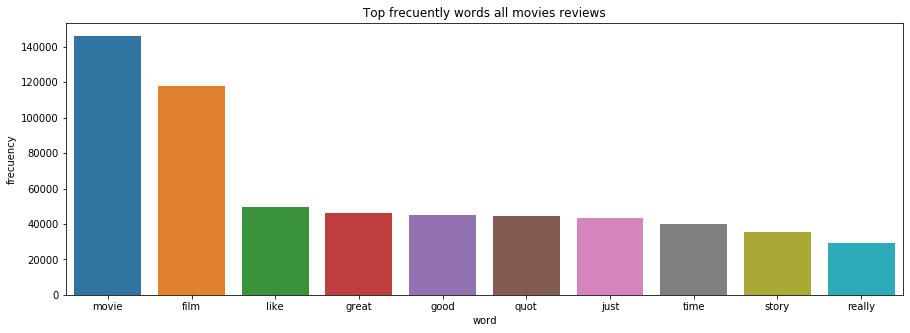

In [38]:
#Graficamos el barplot para all movies review
freq_movies_top=pd.DataFrame(data=freq_movies_top)
freq_movies_top.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently words all movies reviews")
sns.barplot(x="word", y="frecuency", data=freq_movies_top)

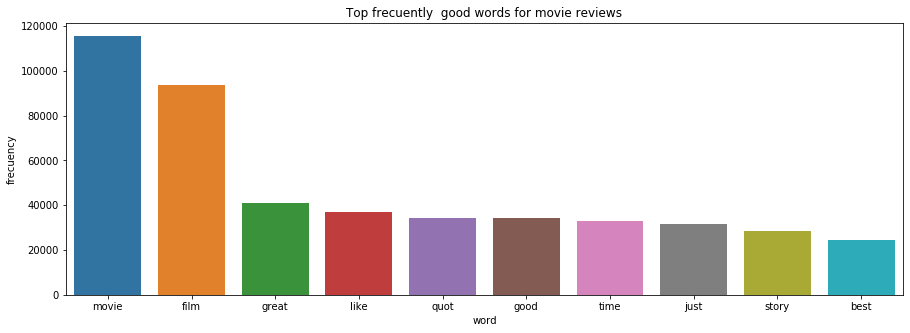

In [45]:
# Graficamos el barplot para good  movies reviews
freq_movies_good_reviews=pd.DataFrame(data=freq_movies_good_reviews)
freq_movies_good_reviews.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently  good words for movie reviews")
sns.barplot(x="word", y="frecuency", data=freq_movies_good_reviews)

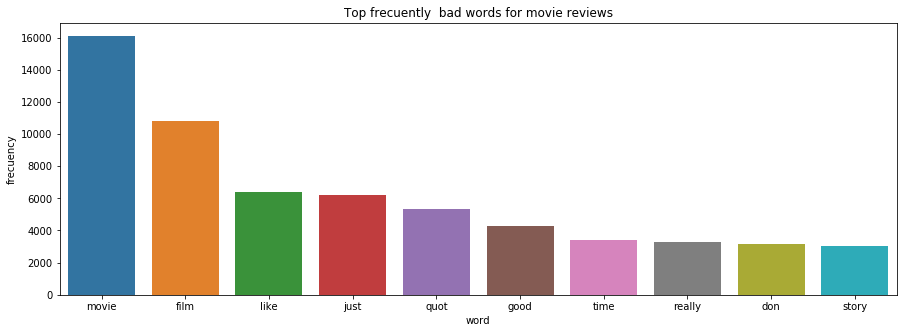

In [43]:
# Graficamos el barplot para bad movies reviews
freq_movies_bad_reviews=pd.DataFrame(data=freq_movies_bad_reviews)
freq_movies_bad_reviews.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently  bad words for movie reviews")
sns.barplot(x="word", y="frecuency", data=freq_movies_bad_reviews)

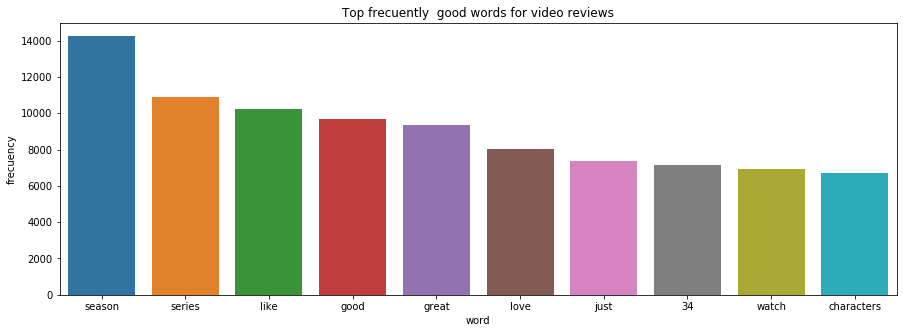

In [46]:
# Graficamos el barplot para good  video reviews
freq_instant_good_reviews=pd.DataFrame(data=freq_instant_good_reviews)
freq_instant_good_reviews.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently  good words for video reviews")
sns.barplot(x="word", y="frecuency", data=freq_instant_good_reviews)

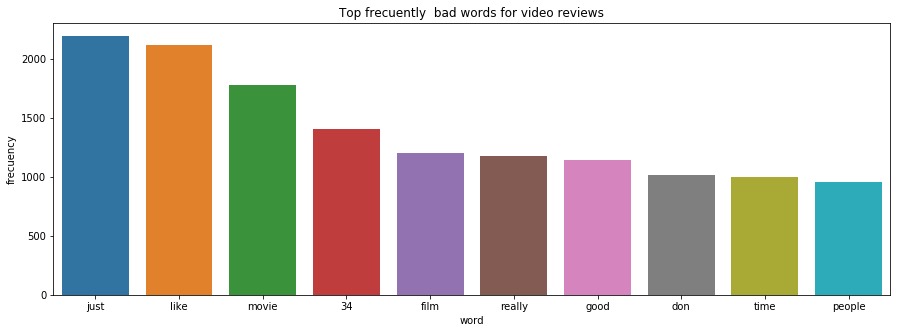

In [39]:
# Graficamos el barplot para bad  video reviews
freq_instant_bad_reviews=pd.DataFrame(data=freq_instant_bad_reviews)
freq_instant_bad_reviews.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently  bad words for video reviews")
sns.barplot(x="word", y="frecuency", data=freq_instant_bad_reviews)

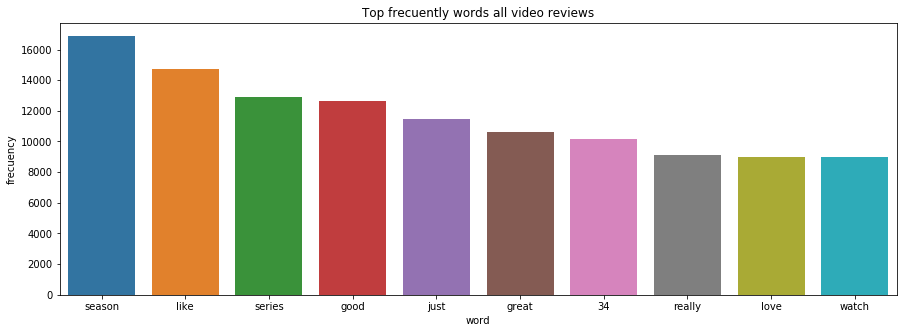

In [37]:
# Graficamos el barplot para all  video reviews
freq_instant_top=pd.DataFrame(data=freq_instant_top)
freq_instant_top.rename(columns={0: 'word', 1: 'frecuency'}, inplace=True)
plt.figure(figsize=(15,5))
plt.title("Top frecuently words all video reviews")
sns.barplot(x="word", y="frecuency", data=freq_instant_top)

--------

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

--------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

--------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

--------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.**

--------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

--------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

--------